In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dynamic_nn_pt as dynn

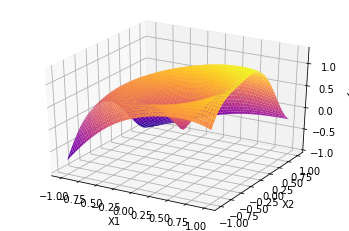

In [3]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1 + (X1+X2)/3

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [724]:
dynet = dynn.Dynamic_Network(2, 1, num_stat=5, num_std=250, decay_rate_std=0.03)
criterion = nn.MSELoss()

In [725]:
### hyperparameters
num_add_neuron = 5
num_decay_steps = 1000
threshold_max = 0.1
threshold_min = 0.001
learning_rate = 0.01

In [753]:
a = torch.zeros(3, requires_grad=True)
a[0]

tensor(0., grad_fn=<SelectBackward>)

### when to stop training functionality

In [726]:
# loss_list = []
# coeff = torch.zeros(1, requires_grad=True)

# _x = torch.linspace(0, 1, steps=100)
# _y = torch.exp(coeff*_x)*(1-_x)
# (_y**2).mean().backward()
# coeff.grad

In [735]:
def update_coeff(num_iter=5, lr=0.9):
    if len(loss_list)<10: return np.array([0]), np.array([0]), float(coeff.data[0])
    
    _t = torch.tensor(loss_list)
#     _t = (_t - _t[-1])/(_t.max()-_t[-1]) ## normalize to make first point at 1 and last at 0 
#     _t = (_t - _t[-1])/(_t[0]-_t[-1]) ## normalize to make first point at 1 and last at 0 
    _t = (_t - _t[-1])/(_t[0]-_t.min()) ## normalize to make first point at 1 and last at 0 
    _t = torch.clamp(_t, -1.1, 1.1)
    _x = torch.linspace(0, 1, steps=len(_t))
    
    for _ in range(num_iter):
        coeff_opt.zero_grad()
        _y = torch.exp(coeff*_x)*(1.00001-_x)*coeff1 + coeff2

        _loss = ((_y - _t)**2).mean()
        if loss>10.:
            print("Loss too high")
            continue
        _loss.backward()
        coeff_opt.step()

        coeff.data = torch.clamp(coeff.data, -20., 20.)
        coeff1.data = torch.clamp(coeff1.data, 0.7, 2.)
        coeff2.data = torch.clamp(coeff2.data, -0.2,0.1)
        
#         coeff.data -= lr*coeff.grad
#     _y = torch.exp(coeff*_x)*(1-_x)
    _y = torch.exp(coeff*_x)*(1-_x)*coeff1 + coeff2

    return _x.numpy(), _t.numpy(), float(coeff.data[0]), _y.data.numpy()

In [736]:
# def get_coeff():
# #     _t = torch.tensor(loss_list)
# #     _t = torch.max(_t, _t[-1]) ## log cant take value below 0.
# #     _t = (_t - _t[-1])/(_t[0]-_t[-1]) ## normalize to make first point at 1 and last at 0 
# #     _x = torch.linspace(0, 1, steps=len(_t))
    
# #     _x_ = _x/(1-_x-1e-7)
# #     _lnt=torch.log(_t)
#     if len(loss_list)<10: return [], [], [0,0]

#     _t = np.array(loss_list)
#     _t = (_t - _t[-1])/(_t[0]-_t[-1]) 
    
#     __t = np.maximum(_t, 1e-7)
#     _x = np.linspace(0.00001, 0.9999, num=len(_t))
    
#     ab = np.polyfit(_x, np.log(__t), 1)#, w=np.sqrt(__t))

#     return (_x, _t, ab)

def get_coeff():
    if len(loss_list)<10: return [], [], 0
    
    _t = np.array(loss_list)
#     _t = (_t - _t[-1])/(_t.max()-_t[-1]) 
    _t = (_t - _t[-1])/(_t[0]-_t[-1]) 
    
    _t = np.clip(_t, 1e-7, 1.)
    _x = np.linspace(0., 1., num=len(_t))
    
#     print(_x, __t)
    c = np.sum(_x*np.log(_t))/(np.sum(_x**2)+1e-7)
    
    return _x, _t, c

def get_coeff2():
    if len(loss_list)<10: return [], [], 0
    
    _t = np.array(loss_list)
#     _t = (_t - _t[-1])/(_t.max()-_t[-1]) 
    _t = (_t - _t[-1])/(_t[0]-_t[-1]) 
#     __t = np.maximum(_t, 1e-7)
    __t = np.clip(_t, 1e-7, 1.)

    _x = np.linspace(0., 1., num=len(_t))
    
#     print(_x, __t)
    __t = np.log(__t)
    c = np.sum(_x*(__t**2))/(np.sum(__t * (_x**2))+1e-7)
    
    return _x, _t, c

## Train Network dynamically

In [737]:
dynet.add_neurons(num_add_neuron)

In [738]:
dynet.print_network()

2
├────┐
│    10
├────┘
│
1


In [749]:
optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)

coeff = torch.zeros(1, requires_grad=True)
coeff1 = torch.zeros(1, requires_grad=True)
coeff2 = torch.zeros(1, requires_grad=True)

coeff_opt = torch.optim.Adam([coeff, coeff1, coeff2], lr=1)
loss_list = []

### Training Step

In [750]:
%matplotlib tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

for epoch in range(10000):

    dynet.decay_neuron_step()
    dynet.tree.std_loss = 0.    

    yout = dynet(xx)
    loss = criterion(yout, yy) + dynet.tree.decay_rate_std*dynet.tree.std_loss
    
#     if epoch>100:
    loss_list.append(float(loss))
    
    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    optimizer.step()
    
    if epoch%100 == 0:
#         __x, __t, _c = update_coeff(5)
#         _x, _t, ab = get_coeff()
#         _c, _b = ab[0], ab[1] 
        _x, _t, _c = get_coeff()


        print(f'Epoch: {epoch}, Loss:{float(loss)}, coeff:{_c}')
        ax.clear()

        ax.scatter(X1, X2, Y, marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        
        ax2.clear()
#         ax2.plot(__x, __t, c='b')
#         ax2.plot(__x, np.exp(_c*__x)*(1-__x), c='r')
        
        if len(_x)>0:
            ax2.plot(_x, _t, c='b')
            ax2.plot(_x, np.exp(_c*_x), c='r')
            
            _x, _t, _c = get_coeff2()
            ax2.plot(_x, np.exp(_c*_x), c='g')
            
            _x, _t, _c, _y = update_coeff(50)
            print(_c)
            ax2.plot(_x, _y, c='m')
            ax2.plot(_x, _t, c='c')
            
            

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        
        if _c < -6: break

plt.close()

Epoch: 0, Loss:0.010921061038970947, coeff:0


Epoch: 100, Loss:0.010811424814164639, coeff:-1.0541965388266255
1.1340067386627197


Epoch: 200, Loss:0.010685158893465996, coeff:-7.02211403249339
0.7820167541503906


Epoch: 300, Loss:0.010479218326508999, coeff:-1.6139432275146957
0.20415562391281128


Epoch: 400, Loss:0.010510249994695187, coeff:-9.046051368072963
-0.4304616451263428


Epoch: 500, Loss:0.01042481791228056, coeff:-3.255937860506367
-0.8733789324760437


Epoch: 600, Loss:0.010451558977365494, coeff:-8.038760025768342
-1.60703444480896


Epoch: 700, Loss:0.010477451607584953, coeff:-13.610487571450658
-2.396974802017212


Epoch: 800, Loss:0.010501221753656864, coeff:-16.891613936577816
-3.2993547916412354


Epoch: 900, Loss:0.010463248938322067, coeff:-12.152807711654402
-3.852386236190796


Epoch: 1000, Loss:0.01044053677469492, coeff:-7.104798560299738
-4.373661994934082


Epoch: 1100, Loss:0.010436389595270157, coeff:-6.194143535810479
-4.936232089996338


Epoch: 1200

In [741]:
coeff, coeff1, coeff2

(tensor([-6.6224], requires_grad=True),
 tensor([1.3497], requires_grad=True),
 tensor([-0.0239], requires_grad=True))

In [743]:
dynet.print_network_debug()

H:0[2,1]σ[t:0.987927674324087, s:0.9352430105209351
|     S:1[2,1]
|     R:1[10|10]
|     |     H:2[2,10]σ[t:0.0, s:0.0
|     |     |     S:3[2,10]
|     |     H:2[10,1]σ[t:0.0, s:0.0
|     |     |     S:3[10,1]


## Compute Significance

In [744]:
dynet.start_computing_significance()

for epoch in range(1):
    yout = dynet(xx)
    yout.backward(gradient=torch.ones_like(yout))
    optimizer.zero_grad()

dynet.finish_computing_significance()

#### start removing less significant neurons

In [745]:
dynet.identify_removable_neurons(num=5,
                                 threshold_min = threshold_min,
                                 threshold_max = threshold_max)

(tensor(0.0984),
 tensor([1.2024, 0.0000, 0.0000, 0.9424, 0.2724, 0.6554, 0.0984, 0.9197, 0.1674,
         0.1906]))

In [746]:
dynet.decay_neuron_start(decay_steps=1000)

3

#### compute del_neuron statstics after removing neurons

In [691]:
dynet.compute_del_neurons()

## Maintain Structure of Network

In [692]:
dynet.maintain_network()

In [693]:
dynet.print_network()

2
├────┐
│    5
├────┘
│
1


In [72]:
len(dynet.tree.DYNAMIC_LIST)

3

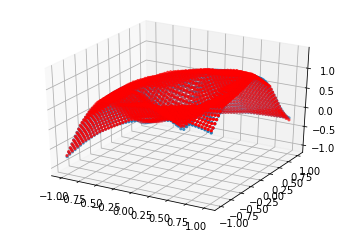

In [705]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')

yout = dynet(xx)
ax.scatter(X1, X2, Y, marker= '.')
ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')